# Projeto 1 - Ci√™ncia dos Dados

Nome: Jo√£o Gabriel Valentim Rocha

Nome: Enzo Dadier Lacks Zamberlan

Aten√ß√£o: Ser√£o permitidos grupos de tr√™s pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisar√£o fazer um question√°rio de avalia√ß√£o de trabalho em equipe

In [61]:
#!pip install seaborn
#!pip install emoji
#!pip install pysinonimos
#!pip install nltk
#!pip install sklearn
#!pip install unidecode

___
Carregando algumas bibliotecas:

In [62]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import seaborn as sn
from nltk import SnowballStemmer
import math

In [63]:
import re
import string
import emoji
import nltk
import pysinonimos.sinonimos as sinom
from emoji import UNICODE_EMOJI
import unidecode

In [64]:
print('Esperamos trabalhar no diret√≥rio')
print(os.getcwd())

Esperamos trabalhar no diret√≥rio
C:\Users\gabri\Desktop\Mat√©rias 2 semestre\cdados\P1\Classificador_automatico_de_sentimentos


Carregando a base de dados com os tweets classificados como relevantes e n√£o relevantes:

In [65]:
filename = 'assets/Loki_aleat√≥rio.xlsx'

In [66]:
train = pd.read_excel(filename)
train

Treinamento  Relevancia
0    @agtha_harkness @mobiusdaavt @pooldeangostoso ...         0.0
1      @chiidenoir amg esquece\nela shippa thor e loki         1.0
2    a menina falando mal de loki puta que pariu se...         1.0
3    @octavio_guedes a t√©cnica para dar volume: ao ...         0.0
4                      @loki__mugo fuliza inanidai ata         0.0
..                                                 ...         ...
793  @clintarqueiro @bracinhodeferro @meupai_eadory...         0.0
794                     eu fico toda coisada pelo loki         1.0
795  @sylvielaufeydit @bracinhodeferro @meupai_eado...         0.0
796                                    @kookvlong pode         0.0
797  amo a epifania q estou tendo com loki pq acho ...         1.0

[798 rows x 2 columns]

In [67]:
test = pd.read_excel(filename, sheet_name = 'Teste')
test

Teste  Relevancia
0            demorou mas finalmente t√¥ assistindo loki           1
1    @benuron_ @beatriz__asf xiu nao quero saber de...           0
2    ·Öü·Öü\n\neu e a tia sylvie atormentando o tio lok...           1
3    vote 24 pra eleger loki como presidente em 202...           1
4                    indo de descer com o loki e mimir           0
..                                                 ...         ...
196  honestamente esperava mais do twitter, fiquei ...           0
197  pq ningu√©m est√° falando sobre a agatha de wand...           1
198  @datrueee @mao77sem @dvszinx9 @kayky9rs @wtfsn...           0
199  vo terminar de ver loki, depois vou ver o film...           0
200  meu deus kkkkkkkkkkkkk a temporada de loki foi...           1

[201 rows x 2 columns]

___
## Classificador autom√°tico de sentimento


Fa√ßa aqui uma descri√ß√£o do seu produto e o que considerou como relevante ou n√£o relevante na classifica√ß√£o dos tweets.

O classificador autom√°tico de sentimentos montado tem como crit√©rio utilizado a relev√¢ncia de tweets que remetam a alguma rea√ß√£o ou la√ßo sentimental em rela√ß√£o √† s√©rie, sendo os mesmos positivos ou n√£o (elogiando algum epis√≥dio, comentando valores da s√©rie, ou ainda, criticando os mesmos). Neste sentido, postagens que dizem respeito unicamente a aspectos nesse tocante, elogiando ou comentando sobre os atores da obra, como tamb√©m tweets com vagas men√ß√µes sobre a s√©rie, foram considerados como irrelevantes.

### Procedimentos e configura√ß√µes iniciais

Para continuarmos, √© necess√°rio definir algumas fun√ß√µes b√°sicas que v√£o nos ajudar:

In [68]:
# Passo 0
def separa_emoji(tweet):
    # Essa fun√ß√£o separa os emojis e transcreve suas respectivas descri√ß√µes
    modified=' '.join(emoji.get_emoji_regexp().split(tweet))
    modified=modified.split()
    for i,emoji1 in enumerate(modified):
        if emoji1 in UNICODE_EMOJI['pt']:
            modified[i]=UNICODE_EMOJI['pt'][emoji1].replace(':','')
        elif emoji1 in UNICODE_EMOJI['en']:
            modified[i]=UNICODE_EMOJI['en'][emoji1].replace(':','')
        else:
            continue
    modified=' '.join(modified)
        
    return modified

In [69]:
# Passo 1
stemmer = SnowballStemmer('portuguese')
def limpa_frase(frase):
    # Primeiro, poe todas as palavras com letras min√∫sculas
    aux = frase.lower()
    
    # Segundo, remove # and @
    aux = re.sub("@[A-Za-z0-9_]+","", aux)
    aux = re.sub("#[A-Za-z0-9_]+","", aux)
    
    # Terceiro, remove links
    aux = re.sub(r"http\S+", "", aux)
    aux = re.sub(r"www.\S+", "", aux)
    
    # Quarto, remove pontua√ß√£o
    aux = re.sub('[()!?]', ' ', aux)
    aux = re.sub('\[.*?\]',' ', aux)
    
    # Quinto, separa e troca os emojis pela sua respectiva descri√ß√£o
    aux = separa_emoji(aux)
    aux = aux.replace("_", "")
    
    # Sexto, remove acentos
    aux = unidecode.unidecode(aux)
    
    # S√©timo, remove n√£o alfa-numericos
    aux = re.sub("[^a-z0-9]"," ", aux)
    
    # Oitavo, aplica Stemming
    aux_2 = ''
    lista_das_palavras = aux.split()
    for palavra in lista_das_palavras:
        nova_palavra = stemmer.stem(palavra)
        aux_2 += nova_palavra + ' '
    aux = aux_2.rstrip()
    
    return aux

In [70]:
# Passo 2
# transforma uma string em uma lista, de tal forma que √© poss√≠vel acessar palavra por palavra
def tokenize(frase):
    return frase.split()

In [71]:
# Passo 3
# Aqui ser√£o contabilizadas as "stop words"
nltk.download('stopwords')
prep = nltk.corpus.stopwords.words('portuguese')
prep.append('')
prep = prep + ['n', 's', 'pq', 'q', 'to', 'pra', 'ja']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [72]:
# Passo 4
# Essa fun√ß√£o retira as stop words de uma lista tokenizada
def no_stop_words(token):
    clear = []
    for element in token:
        if element not in prep:
            clear.append(element)
    return clear

In [73]:
# Passo 5
# Essa fun√ß√£o aplica o stemming, pegando a raiz das palavras
def to_stemmer(aux):
    aux_2 = ''
    lista_das_palavras = aux.split()
    for palavra in lista_das_palavras:
        nova_palavra = stemmer.stem(palavra)
        aux_2 += nova_palavra + ' '
    aux = aux_2.rstrip()
    return aux

In [74]:
# Auxiliar para transformar de lista para string
def list_to_string(lista):
    return ' '.join(lista)

In [75]:
# Fun√ß√£o final que limpa todo tweet e devolve em formato de string
def limpa_tweet(tweet):
    return list_to_string(no_stop_words(tokenize(limpa_frase(tweet))))

In [76]:
# Gera uma pd.Series do set_frases
def frases_to_series(set_frases):
    set_frases += ' '
    return pd.Series(tokenize(set_frases.sum()))

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

In [77]:
# Transformando palavras em vari√°veis categ√≥ricas
train['Treinamento'] = train['Treinamento'].astype('category')
test['Teste'] = test['Teste'].astype('category')

In [78]:
# Aplicando fun√ß√µes de limpeza e certifica√ß√£o no dataframe de treinamento da base de dados
train['Clean'] = train['Treinamento'].apply(limpa_tweet)
test['Clean'] = test['Teste'].apply(limpa_tweet)

In [79]:
# Separa os tweets relevantes dos irrelevantes
train_rel = train[train['Relevancia'] == 1]
train_irrel= train[train['Relevancia'] == 0]

In [80]:
# Gera uma pd.Series das palavras relevantes e irrelevantes do training set
palavras_rel = frases_to_series(train_rel['Clean'])
palavras_irrel = frases_to_series(train_irrel['Clean'])

In [81]:
# Gera duas listas com as palavras relevantes e irrelevantes e gera uma lista total
lista_palavras_rel = list(palavras_rel)
lista_palavras_irrel = list(palavras_irrel)
lista_palavras = lista_palavras_rel + lista_palavras_irrel
lista_palavras_sem_repeticao = list(set(lista_palavras))

In [82]:
# Gera um pd.Series da lista com todas as palavras
palavras = pd.Series(lista_palavras)

In [83]:
# Frequencias relativas
freq_palavras_relevantes = palavras_rel.value_counts(True)
freq_palavras_irrelevantes = palavras_irrel.value_counts(True)
freq_palavras_total = palavras.value_counts(True)

# Frequencias absolutas
freq_palavras_relevantes_abs = palavras_rel.value_counts()
freq_palavras_irrelevantes_abs = palavras_irrel.value_counts()
freq_palavras_total_abs = palavras.value_counts()

print(freq_palavras_relevantes_abs)

lok                     319
nao                      69
seri                     50
rostochorandoaosberr     37
assist                   35
                       ... 
arco                      1
sombri                    1
rostomandandoumbeij       1
condolenc                 1
embor                     1
Length: 1121, dtype: int64


In [84]:
#print(list(freq_palavras_relevantes.keys()))

## Probabilidades 

Aqui abordaremos os valores das probabilidades que ser√£o imprescind√≠veis para a constru√ß√£o do modelo. Em primeiro lugar, note que as probabilidade de serem relevantes ou serem irrelevantes podem ser expressas da seguinte forma:
 
 * $P(R) \rightarrow $  Probabilidade de ser relevante
 * $P(I)=P(R^c) \rightarrow $  Probabilidade de ser irrelevante
 
Al√©m disso, por serem complementares, temos que: $P(R) + P(I) = P(R) + P(R^c) = 1$
 

In [85]:
# Utilizando a raz√£o entre a quantidade de palavras da lista de relevantes pelo n√∫mero total, temos P_R
P_R = len(lista_palavras_rel) / len(lista_palavras)

# Por complementar, temos P_Rc
P_Rc = 1 - P_R

## Probabilidades Condicionais e o Teorema de Bayes
Temos que, para o c√°lculo de probabilidades condicionais, fazemos uso da seguinte rela√ß√£o:

$$P(A|B) = \frac{P(A \cap B)}{P(B)}$$

Onde, 
* $P(A|B) \rightarrow $ Probabilidade de A ocorrer, dado que B ocorreu  
* $P(A \cap B) \rightarrow $ Probabilidade de A ocorrer e B ocorrer
* $P(B) \rightarrow $ Probabilidade de B ocorrer

Analogamente, temos que:
$$P(B|A) = \frac{P(B \cap A)}{P(A)}$$

Onde, 
* $P(B|A) \rightarrow $ Probabilidade de A ocorrer, dado que B ocorreu  
* $P(B \cap A) \rightarrow $ Probabilidade de B ocorrer e A ocorrer
* $P(A) \rightarrow $ Probabilidade de B ocorrer

Note que as probabilidades da interse√ß√£o podem comutar os eventos A e B, portanto: $P(B \cap A) = P(A \cap B)$

Dessa forma, podemos extrair o conhecido Teorema de Bayes:

$$P(A|B) = P(B|A).\frac{P(A)}{P(B)}$$



## O Classificador de Naive Bayes

O Classificador de Naive Bayes se baseia na constru√ß√£o de um modelo bag-of-word. Na an√°lise de sentimento, queremos responder a seguinte pergunta: "Qual a probabilidade dessa frase ser relevante, dado esse conjunto de palavras?". Nesse sentido, √© necess√°rio computar esse c√°lculo utilizando probabilidades condicionais e o resultado do teorema de Bayes encontrado na sess√£o anterior:

$$P(R|frase) = \frac{P(frase|R).P(R)}{P(frase)}$$

Dessa forma, n√≥s vamos usar essa rela√ß√£o para encontrar $P(R|frase)$, ou seja, a probabilidade de uma frase ser relevante, dado o conjunto de palavras. Para tanto, tome como exemplo a frase: "meu av√¥ ama isso", em termos de nota√ß√£o, queremos encontrar:

$$P(R|frase) = \frac{P(frase|R).P(R)}{P(frase)}$$

Para prosseguir, utilizaremos um processo de "Tokeniza√ß√£o", que consiste em dividir a frase em peda√ßos menores (as palavras) e assumir que uma palavra n√£o influencia na coloca√ß√£o da outra. Sabemos que isso n√£o √© verdade, mas utilizaremos por quest√µes de simplifica√ß√£o (essa √© a ingenuidade do classificador de Naive Bayes). Portanto, nosso c√°lculo ficara da seguinte forma:

$$P(frase|R) = P("meu"|R).P("av√¥"|R).P("ama"|R).P("isso"|R)$$

Logo, nossa express√£o final ser√°:

$$P(R|frase) = \frac{P("meu"|R).P("av√¥"|R).P("ama"|R).P("isso"|R).P(R)}{P(frase)}$$

Analogamente, para encontrarmos a probabilidade dele ser irrelevante, podemos fazer o mesmo c√°lculo:

$$P(I|frase) = \frac{P("meu"|I).P("av√¥"|I).P("ama"|I).P("isso"|I).P(I)}{P(frase)}$$

Agora, basta compararmos os valores das probabilidades:

Se, $P(R|frase) > P(I|frase)$, ent√£o, √© mais prov√°vel que a frase seja $relevante$


Caso contr√°rio, $P(R|frase) < P(I|frase)$, ent√£o, √© mais prov√°vel que a frase seja $irrelevante$

### Suaviza√ß√£o de Laplace

√â importante ressaltar que para o caso de uma determina palavra em uma frase n√£o pertencer ao nosso conjunto universo, a probabilidade atribuida a essa palavra ser√° zero. Por√©m, n√£o podemos utilizar a probabilidade de 0 por raz√µes alg√©bricas, portanto, utilizaremos a <b><em>Suaviza√ß√£o de Laplace</em></b>. Basicamente essa ferramenta ir√° nos ajudar a inserir a palavra "estranha" no quesito probabil√≠stico das categorias discutidas.

$$P(palavra|W) = \frac{F_{AW}+1}{P_{W}+P_{P}}$$

Onde: 

$ F_{AW} \rightarrow$ Frequ√™ncia absoluta da palavra na categoria W
    
$P_{W} \rightarrow$ Todas as palavras pertencentes √†s frases rotuladas como da categoria W
    
$P_{P} \rightarrow$ Todas as palavras poss√≠veis sem repeti√ß√£o

Nesse sentido, tome $W$ como sendo o evento $R$ e $W^c$ como sendo o evento $I$ ou $R^C$. Dessa forma, a soma do valor 1 faz com que o nosso resultado de $P(R|frase)$ ou $P(I|frase)$ nunca se torne zero, mesmo que a frequ√™ncia absoluta da palavra seja zero.


In [86]:
'''
A suaviza√ß√£o de Laplace ser√° utilizada para os casos em que uma determinada palavra da frase n√£o se encontra 
no conjunto universo.
'''
def smoothing(palavra, relevancia, freq_palavras_abs, alfa=1):
    '''
    alfa -> Par√¢metro de suaviza√ß√£o
    alfa = 1 (Suaviza√ß√£o de Laplace)
    alfa < 1 (Suaviza√ß√£o de Lidstone)
    '''
    try:
        FAW = freq_palavras_abs[palavra]
    except:
        FAW = 0
    if relevancia == 'R':
        return (FAW + alfa) / (len(lista_palavras_rel) + alfa * len(lista_palavras_sem_repeticao))
    return (FAW + alfa) / (len(lista_palavras_irrel) + alfa * len(lista_palavras_sem_repeticao))

In [87]:
# Fun√ß√£o que calcula a probabilidade que queremos para fazer a desigualdade e decidir a categoria mais prov√°vel
def P(relevancia, frase):
    if type(frase) != list:
        frase = tokenize(frase)
    if relevancia == 'R':
        P_F_dado_R = 1
        for palavra in frase:
            P_F_dado_R *= smoothing(palavra, relevancia, freq_palavras_relevantes_abs)
        P_R_dado_F = P_F_dado_R * P_R
        return P_R_dado_F
            
    elif relevancia == 'I' or relevancia == 'Rc':
        P_F_dado_Rc = 1
        for palavra in frase:
            P_F_dado_Rc *= smoothing(palavra, relevancia, freq_palavras_irrelevantes_abs)
        P_Rc_dado_F = P_F_dado_Rc * P_Rc
        return P_Rc_dado_F
    return None

In [88]:
# Fun√ß√£o final que recorre ao modelo de Naive Bayes
def NaiveBayesModel(frase):
    if P('R', frase) > P('I', frase):
        return 1
    return 0

In [89]:
# Fun√ß√£o final que recorre ao modelo de Naive Bayes
def NaiveBayesModel_MonteCarlo(frase):
    p1 = P('R', frase)
    p2 = P('I', frase)
    if p1 > 0.6 or p2 > 0.6:
        if p1 > p2:
            return 1
        return 0
    else:
        p1_plus_p2 = p1 + p2
        lambda_1 = p1 / p1_plus_p2
        lambda_2 = p2 / p1_plus_p2
        z = random.random()
        if z < lambda_1:
            return 1
        return 0

### An√°lise do classificador utilizando a pr√≥pria base de dados

Aqui utilizaremos o classificador para ver sua performance com sua pr√≥pria base de dados. O intuito √© checar a possibilidade de overfitting.

In [90]:
tabela_train = train.copy()

In [91]:
tabela_train['Modelo'] = tabela_train['Clean'].apply(NaiveBayesModel)
tabela_train

Treinamento  Relevancia  \
0    @agtha_harkness @mobiusdaavt @pooldeangostoso ...         0.0   
1      @chiidenoir amg esquece\nela shippa thor e loki         1.0   
2    a menina falando mal de loki puta que pariu se...         1.0   
3    @octavio_guedes a t√©cnica para dar volume: ao ...         0.0   
4                      @loki__mugo fuliza inanidai ata         0.0   
..                                                 ...         ...   
793  @clintarqueiro @bracinhodeferro @meupai_eadory...         0.0   
794                     eu fico toda coisada pelo loki         1.0   
795  @sylvielaufeydit @bracinhodeferro @meupai_eado...         0.0   
796                                    @kookvlong pode         0.0   
797  amo a epifania q estou tendo com loki pq acho ...         1.0   

                                                 Clean  Modelo  
0                                                 ajud       0  
1                            amg esquec shipp thor lok       1  
2           menin fal mal lok put par mat put bom gost       1  
3    tecnic par dar volum inves convoc manifestaco ...       0  
4                                    fuliz inanida ata       0  
..                                                 ...     ...  
793                                               amor       0  
794                               fic tod cois pel lok       1  
795                                 sei ate oq vai fal       0  
796                                                pod       0  
797  amo epifan tend lok acho sent tud sent vend ab...       1  

[798 rows x 4 columns]

In [92]:
verdadeiros_positivos = tabela_train.loc[(tabela_train['Modelo'] == 1) & (tabela_train['Relevancia'] == 1),:].shape[0]
falsos_positivos = tabela_train.loc[(tabela_train['Modelo'] == 1) & (tabela_train['Relevancia'] == 0),:].shape[0]
print(f'O percentual de verdadeiros positivos foi de: {100*(verdadeiros_positivos)/tabela_train.shape[0]:.2f}%')
print(f'O percentual de falsos positivos foi de: {100*(falsos_positivos)/tabela_train.shape[0]:.2f}%')

O percentual de verdadeiros positivos foi de: 34.96%
O percentual de falsos positivos foi de: 6.27%


In [93]:
verdadeiros_negativos = tabela_train.loc[(tabela_train['Modelo'] == 0) & (tabela_train['Relevancia'] == 0),:].shape[0]
falsos_negativos = tabela_train.loc[(tabela_train['Modelo'] == 0) & (tabela_train['Relevancia'] == 1),:].shape[0]
print(f'O percentual de verdadeiros negativo foi de: {100*(verdadeiros_negativos)/tabela_train.shape[0]:.2f}%')
print(f'O percentual de falsos negativo foi de: {100*(falsos_negativos)/tabela_train.shape[0]:.2f}%')

O percentual de verdadeiros negativo foi de: 57.14%
O percentual de falsos negativo foi de: 1.50%


In [94]:
print(f'A acur√°cia do modelo foi de: {100*(verdadeiros_negativos+verdadeiros_positivos)/tabela_train.shape[0]:.2f}%')

A acur√°cia do modelo foi de: 92.11%


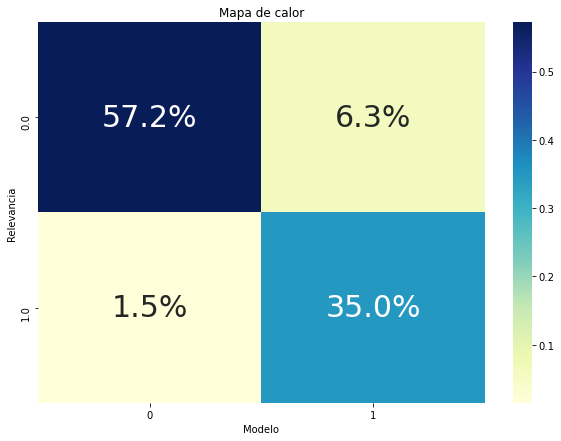

In [95]:
tabela_cruzada_ = pd.crosstab(tabela_train.Relevancia, tabela_train.Modelo, normalize=True)
plt.figure(figsize=(10,7))
plt.title('Mapa de calor')
sn.heatmap(tabela_cruzada_, annot=True, annot_kws={"size": 30}, fmt='.1%', cmap='YlGnBu')
plt.show()

___
### Verificando a performance do Classificador

Agora voc√™ deve testar o seu classificador com a base de Testes.

In [96]:
test['Modelo'] = test['Clean'].apply(NaiveBayesModel)

In [97]:
verdadeiros_positivos = test.loc[(test['Modelo'] == 1) & (test['Relevancia'] == 1),:].shape[0]
falsos_positivos = test.loc[(test['Modelo'] == 1) & (test['Relevancia'] == 0),:].shape[0]
print(f'O percentual de verdadeiros positivos foi de: {100*(verdadeiros_positivos)/test.shape[0]:.2f}%')
print(f'O percentual de falsos positivos foi de: {100*(falsos_positivos)/test.shape[0]:.2f}%')

O percentual de verdadeiros positivos foi de: 27.36%
O percentual de falsos positivos foi de: 27.36%


In [98]:
verdadeiros_negativos = test.loc[(test['Modelo'] == 0) & (test['Relevancia'] == 0),:].shape[0]
falsos_negativos = test.loc[(test['Modelo'] == 0) & (test['Relevancia'] == 1),:].shape[0]
print(f'O percentual de verdadeiros negativo foi de: {100*(verdadeiros_negativos)/test.shape[0]:.2f}%')
print(f'O percentual de falsos negativo foi de: {100*(falsos_negativos)/test.shape[0]:.2f}%')

O percentual de verdadeiros negativo foi de: 38.81%
O percentual de falsos negativo foi de: 6.47%


In [99]:
print(f'A acur√°cia do modelo foi de: {100*(verdadeiros_negativos+verdadeiros_positivos)/test.shape[0]:.2f}%')

A acur√°cia do modelo foi de: 66.17%


In [100]:
# Fun√ß√£o importante para o √∫ltimo item desse projeto
def calcula_metricas(testing):
    verdadeiros_positivos = testing.loc[(testing['Modelo'] == 1) & (testing['Relevancia'] == 1),:].shape[0]
    falsos_positivos = testing.loc[(testing['Modelo'] == 1) & (testing['Relevancia'] == 0),:].shape[0]
    verdadeiros_negativos = testing.loc[(testing['Modelo'] == 0) & (testing['Relevancia'] == 0),:].shape[0]
    falsos_negativos = testing.loc[(testing['Modelo'] == 0) & (testing['Relevancia'] == 1),:].shape[0]
    acuracia = (verdadeiros_negativos+verdadeiros_positivos)
    return (verdadeiros_positivos * 100)/test.shape[0], (falsos_positivos * 100)/test.shape[0], (verdadeiros_negativos * 100)/test.shape[0], (falsos_negativos * 100)/test.shape[0], (acuracia * 100)/test.shape[0]

#### Mapa de Calor
Para visualizar melhor os percentuais, vamos utilizar a biblioteca Seaborn para plotar um mapa de calor, a partir de uma tabela cruzada que ser√° criada na c√©lula seguinte.

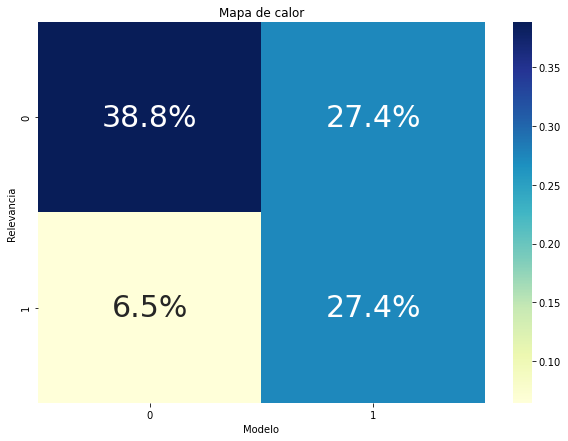

In [101]:
tabela_cruzada = pd.crosstab(test.Relevancia, test.Modelo, normalize=True)
plt.figure(figsize=(10,7))
plt.title('Mapa de calor')
sn.heatmap(tabela_cruzada, annot=True, annot_kws={"size": 30}, fmt='.1%', cmap='YlGnBu')
plt.show()

___
### Concluindo

   No classificador autom√°tico criado, que tem por objetivo adotar crit√©rios acerca dos sentimentos sobre a s√©rie, como visto  no mapa de calor e seus dados de precis√£o, h√° uma acur√°cia de 53.50%, com um percentual de verdadeiros negativo de 37.50% e um percentual de falsos negativo de 18.00%.
   
   Dentro deste universo, √© essencial acrescentar que os grandes respons√°veis por esses erros s√£o os falsos positivos, j√° que trazem uma caracteriza√ß√£o err√¥nea ao classificador em quest√£o. Desta forma, tamb√©m √© importante destacar que ao promover o uso de um data base pequeno, o algor√≠tmo criado apresenta uma classifica√ß√£o mais arbritr√°ria, enquanto que se a mesma for feita por mais informa√ß√µes e informa√ß√µes mais abrangentes, apresentar√° resultados mais satisfat√≥rios e precisos, dentro de uma 'subjetividade' criada por probabilidades e espa√ßos amostrais que envolvem os dados em quest√£o. Com isso, sendo poss√≠vel receber um output biin√°rio respos√°vel por definir os mesmos em relevantes, ou ainda, irrelevantes. Ou seja, classificar automaticamente os dados em quest√£o.
  
   Contudo, pode-se definir, por fim, um funcionamento adequado ao pr√≥prio classificador, mas n√£o ideal, sendo que uma vez que "naive" (ou seja, ing√™nuo) desconsidera a rela√ß√£o entre as palavras, abrindo brechas para classifica√ß√µes incorretas acerca dos procedimentos de sarcasmo, dupla nega√ß√£o, ironia, ambiguidade e figuras de linguagem - sendo sarcasmo e dupla nega√ß√£o discutidos abaixo. Fato que mesmo o aumento dos dados coletados por ele podem n√£o sanar, tendo em mente apenas a efic√°cia da an√°lise matem√°tica e n√£o de gran√°tica, sentido ou sintaxe aplicadas aos tweets.
   
   Atrav√©s disso, tendo em vista o funcionamento adequado do produto em quest√£o (dentro de aspectos matem√°ticos), essa funcionalidade poderia de fato ser expandida para outros universos, como a compara√ß√£o de avalia√ß√µes positivas e negativas acerca de um determinado produto, ou ainda, coletando a relev√¢ncia de feedbacks apresentados pelos usu√°rios de determidao produto-servi√ßo, a fim de potencializar a sua efic√°cia e produtividade. Deste modo, sendo intr√≠nseco ao projeto a necessidade cont√≠nua de alimenta√ß√£o financeira, para que o classificador criado possa continuar em andamento, se desenvolvendo e abrangindo maiores ramos no mundo de coleta e classifica√ß√£o de dados, tanto para pesquisa de satisfa√ß√£o quanto para melhoria dos ideias de certa empresa.

#### Por que a acur√°cia do classificador √© maior quando se utiliza a pr√≥pria base de treinamento e menor quando se utiliza a base de teste?

Sobretudo, num contexto de um pequeno data set, ocorrer√° um efeito chamado <b>Overfitting</b>, que ocorre devido ao fato de o conjunto de treinamento n√£o ser suficientemente grande para gerar classifica√ß√µes mais acertivas quando o sistema recebe novas inst√¢ncias (novos tweets). Em outras palavras, o classificador se ajusta muito bem ao conjunto de treinamento, por√©m n√£o possui uma generaliza√ß√£o significativa na classifica√ß√£o do conjunto de teste.

Esse efeito pode ser simbolizado pelo gr√°fico a seguir:

<img src="assets/overfitting_2.png" width=400 >
<center><b>Figura 1 - Visualiza√ß√£o do overfitting para data sets pequenos</b></center>

####  Por que n√£o posso alimentar minha base de Treinamento automaticamente usando o pr√≥prio classificador?

Como vimos anteriormente, existe uma simplifica√ß√£o que fizemos na implementa√ß√£o do modelo que pode prejudicar o julgamento do algoritmo ao receber uma nova inst√¢ncia (novo tweet). Em t√≥picos anteriores vimos que as considera√ß√µes foram estritamente alg√©bricas, n√£o levando em conta o valor sem√¢ntico, gram√°tico e a influ√™ncia de uma palavra √†s demais da frase.

Nesse sentido, ao utilizarmos o pr√≥prio classificador para alimentar a base de treinamento, estar√≠amos propagando um vi√©s cada vez maior, prejudicando o treinamento do nosso modelo. Dessa forma, √© preciso que os tweets sejam rotulados manualmente e com um crit√©rio est√°tico, mesmo que isso apresente um certo grau de subjetividade. √â importante mencionar que esse tipo de sistema de aprendizado √© Supervisionado, portanto, √© necess√°rio que nosso conjunto de treinamento esteja rotulado de forma adequada para que obtenhamos o m√°ximo de √™xito ao classificar uma nova inst√¢ncia.



### Sarcasmo e dupla nega√ß√£o

<b>1) Sarcasmo</b>

Este t√≥pico √© pautado em uma considera√ß√£o que fizemos para a constru√ß√£o do modelo. Como vimos, por quest√µes de simplifica√ß√£o, o classificador de Naive Bayes considera a independ√™ncia entre as palavras (<b>a ingenuidade de Naive Bayes</b>). Apesar de ser uma considera√ß√£o razo√°vel, √© poss√≠vel prever que o classificador n√£o funciona muito bem diante de um tweet sarc√°stico, por exemplo. 

Diante disso, acompanhe um caso que pode ser um bom exemplo disso:

In [102]:
frase_1 = 'eu amo loki tanto quanto tomar uma paulada'
if NaiveBayesModel(frase_1) == 1:
    print('A frase 1 √© RELEVANTE')
else:
    print('A frase 1 √© IRRELEVANTE')

A frase 1 √© RELEVANTE


<b>2) Dupla Nega√ß√£o</b>

Analogamente ao caso anterior, √© poss√≠vel estender essa an√°lise para frases com dupla nega√ß√£o. 

Diante disso, acompanhe um caso que pode ser um bom exemplo disso:


In [103]:
frase_2 = 'loki n√£o √© nada agrad√°vel'
if NaiveBayesModel(frase_2) == 1:
    print('A frase 2 √© RELEVANTE')
else:
    print('A frase 2 √© IRRELEVANTE')

A frase 2 √© RELEVANTE


Com os exemplos acima √© poss√≠vel inferir, portanto, que tweets de car√°ter sarc√°stico ou com dupla nega√ß√£o muito provavelmente ser√£o classificados de maneira err√¥nea. Isso se deve, sobretudo, √† <b>ingenuidade do classificador de Naive Bayes</b>. 

### Novos cen√°rios para o classificador de Naive Bayes

<b>1)</b> A aplica√ß√£o do modelo ing√™nuo de Bayes para prever a doen√ßa de Alzheimer a partir de dados de todo o genoma (Wei Wei, et al. 2011)

Nesse artigo, √© utilizado o modelo de Naive Bayes para identificar e prever a doen√ßa de Alzheimer. O ponto princ√≠pio da implementa√ß√£o se encontro no t√≥pico "<b>The naive Bayes model</b>", onde ele mostra a considera√ß√£o que aqui discutimos:

<img src="assets/ox_article.png" width=400 >
<center><b>Figura 1 - Considera√ß√£o da Ingenuidade do modelo</b></center>

Nesse caso, as features s√£o os componentes pertencentes ao genoma (fazendo o paralelo, seriam a substitui√ß√£o das palavras dos nossos tweets). Dessa forma, √© poss√≠vel ver uma primeira grande aplica√ß√£o para o modelo de Naive Bayes, que ainda n√£o havia sido discutida.

* Fonte: https://academic.oup.com/jamia/article/18/4/370/732731?login=true

<b>2)</b> Uma nova aplica√ß√£o do classificador Naive Bayes na previs√£o de energia fotovoltaica (Ramazan Bayindir, et al. 2017)

Nesse artigo, √© utilizado o modelo de Naive Bayes para identificar e prever a quantidade de energia gerada por paineis fotovoltaicos. Os pesquisadores utilizaram um conjunto de dados coletados por 1 ano, que registram valores de varias features como temperatura e dura√ß√£o total do sol. 

As aplica√ß√µes do modelo de Naive Bayes nesse artigo podem ser de fundamental import√¢ncia no mundo contempor√¢nea, haja vista a necessidade de cada vez mais aplica√ß√µes de energias limpas (como a energia solar) e para tanto, √© necess√°rio um aparato tecnol√≥gico consistente para tal atividade.

* Fonte: https://ieeexplore.ieee.org/abstract/document/8260684

<b>3)</b> Filtro de spam utilizando o modelo de Naive Bayes (DILIP KUMAR, et al. 2018)

Nesse artigo do famoso site Kaggle, √© poss√≠vel ver uma aplica√ß√£o muito interessante (e presente no nosso cotidiano) de um filtro de Spam utilizando o modelo de Naive Bayes. Com um grande n√∫mero de e-mails j√° rotulados, ser√° poss√≠vel criar o modelo exatamente como fizemos nesta aplica√ß√£o. Portanto, temos uma mudan√ßa significativa de ambiente, por√©m utilizaremos o mesmo sistema de aprendizado para tal.


* Fonte: https://www.kaggle.com/dilip990/spam-ham-detection-using-naive-bayes-classifier

### Sugest√µes de melhorias para o Classificador

##### 1) Stemming and Lemmatization

   O stemming de palavras pode ser um caminho muito pertinente para a melhoria da acur√°cia (Utilizado nesse projeto). A t√©cnica consiste em transformar as palavras da frase em sua raiz (que pode acabar resultando em palavras que n√£o existe). Em contrapartida, o Lemmatization obt√©m sua forma canonica e gramaticalmente correta. Ambas as t√©cnicas despendem um grande custo computacional e impactam a performance da classifica√ß√£o, por√©m podem ser uma solu√ß√£o para elevar o percentual de acur√°cia.
   
   Nesse sentido, √© poss√≠vel utilizar a biblioteca de linguagem natural <b>(nltk - Natural Language Toolkit)</b>, caso voc√™ n√£o tenha essa biblioteca instalada utilize o comando:

>**!pip install nltk**

   * Para mais informa√ß√µes, acesse o site oficial: https://www.nltk.org/
   
   * Outro link que pode ajudar: [Artigo Datacamp tutorial](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=278443377095&utm_targetid=aud-392016246653:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1001773&gclid=Cj0KCQjwv5uKBhD6ARIsAGv9a-xGXnN7nhmmTGQ-Fdgb38Qz92hH3S3LnFQOyoOz1Mta4OCa4enwGg8aAseSEALw_wcB)

##### 2) Forma√ß√£o de N-gramas de palavras

   A forma√ß√£o de N-gramas pode contrabalancear o problema da Ingenuidade do modelo. A considera√ß√£o de que as palavras s√£o independentes umas das outras, apesar de funcionar, prejudica o julgamento do sistema de aprendizado para novas inst√¢ncias. Logo, uma maneira de deixar o modelo mais s√≥lido √© construir N-gramas na forma√ß√£o das palavras.
   Segundo estudos (Vlado KeÀáselj, et al 2003), √© poss√≠vel melhorar significativamente a acur√°cia de textos em ingl√™s utilizando N-gramas com N entre 4 e 8. Portanto, um t√≥pico que poderia ser abordado √© a forma√ß√£o de N-gramas.
   
   Nesse sentido, √© poss√≠vel utilizar a biblioteca de linguagem natural <b>(nltk - Natural Language Toolkit)</b>, caso voc√™ n√£o tenha essa biblioteca instalada utilize o comando:

>**!pip install nltk**

   Com a biblioteca instalada, utilize os comandos a seguir para gerar seus N-gramas (lembre-se da tokeniza√ß√£o):

In [104]:
# import nltk
my_text = 'Estou interessado em aprender Machine Learning'
words = tokenize(my_text)
my_bigrams = nltk.bigrams(words)
my_trigrams = nltk.trigrams(words)
for word in my_bigrams:
    print(word)
for word in my_trigrams:
    print(word)

('Estou', 'interessado')
('interessado', 'em')
('em', 'aprender')
('aprender', 'Machine')
('Machine', 'Learning')
('Estou', 'interessado', 'em')
('interessado', 'em', 'aprender')
('em', 'aprender', 'Machine')
('aprender', 'Machine', 'Learning')


* Para mais informa√ß√µes, acesse o site oficial: https://www.nltk.org/

##### 3) Aumentar o tamanho da base de dados de treinamento

   Das v√°rias propostas poss√≠veis, essa √© uma das mais intuitivas. Em t√≥picos anteriores, falamos a respeito dos efeitos negativos de se utilizar uma base de dados pequena, ao aumentarmos o nosso conjunto de amostras (lembre-se do bag of word model) daremos mais inst√¢ncias para o nosso sistema se basear e aprender a classificar inst√¢ncias n√£o vistas antes. 

Dessa forma, uma sa√≠da poss√≠vel √© classificarmos cada vez mais tweets para alimentar mais nossa base de treinamente e conferir maior acur√°cia para nosso modelo.

##### 4) Utiliza√ß√£o do m√©todo de Monte Carlo para vari√°veis aleat√≥rias

   Como vimos at√© aqui, o modelo de Naive Bayes utiliza a compara√ß√£o de duas probabilidades condicionais atrav√©s do teorema de Bayes. Para decidir a relev√¢ncia ou n√£o, s√≥ verificamos qual probabilidade √© maior e atribuimos a esta a classifi√ß√£o da nova inst√¢ncia. Por√©m, apesar de ser considerada a mais prov√°vel, ainda √© poss√≠vel que a menos prov√°vel seja a classifica√ß√£o real. Aqui entra o m√©todo de Monte Carlo. √â poss√≠vel gerar n√∫meros aleat√≥rio no intervalo de 0 a 1, caso o n√∫mero gerado seja menor que a probabilidade de ser relevante dado um tweet, essa inst√¢ncia ser√° classificada como relevante, caso contr√°rio, como irrelevante. Vale ressaltar que esse m√©todo provavelmente ser√° mais eficaz quando a base de dados for suficientemente grande.

___
### Qualidade do Classificador a partir de novas separa√ß√µes dos tweets entre Treinamento e Teste

Esse t√≥pico √© imprescind√≠vel de se realizar no referido projeto. Isso se deve, sobretudo, ao estudo da performance do classificador ao juntar todos os dados dispon√≠veis e criar novos conjuntos de treinamento e test. A utiliza√ß√£o de uma √∫nica disposi√ß√£o de conjuntos pode prejudicar a performance do classificador. Dessa forma, nesse t√≥pico criaremos um histograma para contar as frequ√™ncias das porcentagens de acur√°cia para diferentes conjuntos de treinamento e teste. 

In [105]:
test_split = pd.read_excel(filename, sheet_name = 'Teste').rename(columns={'Teste':'Total'})

train_split = pd.read_excel(filename, sheet_name = 'Treinamento').rename(columns={'Treinamento':'Total'})

#Concatenando
full_data = pd.concat([train_split,test_split])

#Limpando os tweets
full_data['Clean']=full_data['Total'].apply(limpa_tweet)
full_data.head()

Total  Relevancia  \
0  @agtha_harkness @mobiusdaavt @pooldeangostoso ...         0.0   
1    @chiidenoir amg esquece\nela shippa thor e loki         1.0   
2  a menina falando mal de loki puta que pariu se...         1.0   
3  @octavio_guedes a t√©cnica para dar volume: ao ...         0.0   
4                    @loki__mugo fuliza inanidai ata         0.0   

                                               Clean  
0                                               ajud  
1                          amg esquec shipp thor lok  
2         menin fal mal lok put par mat put bom gost  
3  tecnic par dar volum inves convoc manifestaco ...  
4                                  fuliz inanida ata

In [106]:
# Biblioteca necess√°ria para fatiamento do conjunto de dados totais
from sklearn.model_selection import train_test_split

In [139]:
# Realiza o fatiamento do conjunto total 100 vezes de maneira aleat√≥ria
lista_hist=[]

for i in range(100):
    
    #training_data, testing_data = train_test_split(full_data, test_size=0.2, random_state=random.randint(1,500))
    
    X_train, X_test, y_train, y_test = train_test_split(full_data[['Clean','Relevancia']],full_data.Relevancia,
    test_size=0.3)
    
    train_rel_new = X_train[X_train['Relevancia']==1]
    train_irrel_new = X_train[X_train['Relevancia']==0]
    
    palavras_rel = frases_to_series(train_rel_new['Clean'])
    palavras_irrel = frases_to_series(train_irrel_new['Clean'])
    
    # Gera duas listas com as palavras relevantes e irrelevantes e gera uma lista total
    lista_palavras_rel = list(palavras_rel)
    lista_palavras_irrel = list(palavras_irrel)
    lista_palavras = lista_palavras_rel + lista_palavras_irrel
    lista_palavras_sem_repeticao = list(set(lista_palavras))
    total = pd.Series(lista_palavras)

    # Frequencias absolutas
    freq_palavras_relevantes_abs = palavras_rel.value_counts()
    freq_palavras_irrelevantes_abs = palavras_irrel.value_counts()
    freq_palavras_total_abs = palavras.value_counts()

    P_R = len(lista_palavras_rel) / len(total)

    # Por complementar, temos P_Rc
    P_Rc = len(lista_palavras_irrel) / len(total)
    
    assert P_R+P_Rc==1

    X_test['Modelo'] = X_test['Clean'].apply(NaiveBayesModel)

    verdadeiros_positivos = X_test.loc[(X_test['Modelo'] == 1) & (X_test['Relevancia'] == 1),:].shape[0]
    verdadeiros_negativos = X_test.loc[(X_test['Modelo'] == 0) & (X_test['Relevancia'] == 0),:].shape[0]
    acuracia = (verdadeiros_positivos + verdadeiros_negativos)/X_test.shape[0]
    lista_hist.append(acuracia * 100)

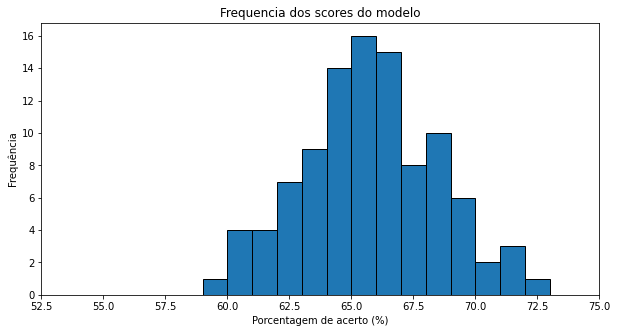

In [140]:
faixa=np.arange(30,99,1)
plt.figure(figsize=(10, 5))
plt.hist(lista_hist, bins=faixa, edgecolor='black', density=False)
plt.title('Frequencia dos scores do modelo')
plt.ylabel('Frequ√™ncia')
plt.xlabel('Porcentagem de acerto (%)')
plt.xlim(52.5,75)
plt.show()

In [141]:
print('Score m√°ximo: ', round(max(lista_hist), 2))
print('Score m√≠nimo: ', round(min(lista_hist), 2))
print('Score m√©dio: ', round(sum(lista_hist)/len(lista_hist), 2))

Score m√°ximo:  72.33
Score m√≠nimo:  59.33
Score m√©dio:  65.55


 * Como podemos ver, a maneira como dispomos os conjuntos de teste e treino pode influenciar no score que o modelo pode alcan√ßar. Tendo isso me vista, √© imprescind√≠vel que estudos com diferentes disposi√ß√µes de conjuntos sejam feitas como no item anterior. Analisando o histograma, podemos observar que n√£o seria produtivo utilizar uma √∫nica parti√ß√£o de conjunto de treinamento/teste, pelo falo de existir a possibilidade tanto de se obter scores elevados quanto de se obter scores mais baixos. Dessa forma, para a melhor constru√ß√£o do sistema de aprendizado, √© imprescind√≠vel que se leve em considera√ß√£o as parti√ß√µes de treinamento/teste que melhor se adequam aos objetivos do projeto.

___
## Subclassifica√ß√µes:

*Categorias Intermedi√°rias*

Criando categorias intermedi√°rias baseadas na probabilidade relativa estipulada pelo modelo

Aqu√©m das categorias Relevante e Irrelevante √© poss√≠vel determinar subclassifica√ß√µes como: Muito Irrelevante, Irrelevante, Neutro, Reletante e Muito Relevante.

Sendo o tweet X e Y, ambos classificados como relevantes. Na nova classifica√ß√£o considera-se que caso a probabilidade de um X ser relevante seja consideravelmente maior do que a probabilidade de um Y ser relevante, pode-se dividir essa classe em mais duas categorias. Sendo assim, tweet X a pertence a subcategoria mais relevante, enquanto que o tweet Y faz parte da menos relevante, ambos dentro da categoria "Relevante" (com graus da mesma distintos). Da mesma forma tweets "Irrelevantes" podem ser classificados, j√° que dentro de suas probabilidades negativas, encontram-se twees mais irrelevantes e menos irrelevantes.

Sendo assim, no caso de um tweet w, que por sua vez, possui uma diferen√ßa de probabilidade ($P(R|tweetW)-P(I|tweetW)$) pr√≥xima de zero, pode-se subclassific√°-lo como um tweet neutro (ou seja, nem relevante e nem irrelevante).

In [110]:
def f_absoluta(palavra,f_abs):
    """
    Determina as vezes que a palavra apareceu 
    na respectiva categoria, sendo ela relevante ou irrelevante
    """

    try:
        return f_abs[palavra]
    
    except:
        return 0

def P_f (Relevancia, tweet):
    return P("R", tweet)*P_R/(P(Relevancia, tweet))

In [111]:
def Naive_Bayes_categories(tweet):
    """
    Diferen√ßa entre as probabilidades de Relevante
    e Irrelevante
    """
    return ((P("R",tweet)*P_R)/P_f('R', tweet)) -((P("I",tweet)*P_Rc)/P_f('I', tweet))

# OBS: a fun√ß√£o P (Fun√ß√£o que calcula a probabilidade que queremos para fazer a desigualdade e decidir a categoria mais 
# prov√°vel) foi reutilizada! 

In [112]:
test_degree=test.copy()
test_degree['Prob']=test_degree['Clean'].apply(Naive_Bayes_categories)
test_degree.Prob

0      8.783659e-11
1     -8.719414e-20
2      5.798516e-15
3      3.867131e-22
4     -3.003391e-11
           ...     
196    3.544064e-29
197    1.439756e-27
198   -9.932591e-09
199   -4.579473e-39
200    1.021896e-31
Name: Prob, Length: 201, dtype: float64

In [113]:

def Categories(p):
    
    '''
   Rotula em: Muito Irrelevante, Irrelevante, Neutro, Relevante ou Muito Relevante
    '''
    
    #Lista com os valores de probabilidade em ordem.
    p_lista = test_degree.Prob.sort_values().tolist()
    
    #Ponto que divide relevantes e irrelevantes na lista ordenada de probabilidade.
    virada = 0
    
    #√öltimo elemento da lista:
    ultimo = len(p_lista)
    
    for i, value in enumerate(p_lista):
            
            if(value < 0):           
                continue
            else:
                #Posi√ß√£o em que os valores mudam para positivo
                virada = i                 
                break
    
    #Probabilidade neutra para valores pr√≥ximos de 0
    if p in p_lista[virada - 10 : virada + 20]:
         return 'Neutro'                       
    
    
    else:    
        
        # Probabilidade negativa 2 Subclasses
        if p < 0:
            
            # Muito Irrelevantes (muito  negativos)
            if p in p_lista[0 : math.ceil((virada - 10) / 2)]:
                return 'Muito Irrelevante'
            
            # Irrelevantes (negativos)
            return 'Irrelevante'
        
        # Probabilidade positiva 2 subclasses
        else:
            
            # Relevantes (menos positivos)
            if p in p_lista[(virada + 20) : math.ceil((virada + 20) + (ultimo - (virada + 20)) / 2)]:
                return 'Relevante'
            
            # Muito Relevantes (Valores mais positivos)
            return 'Muito Relevante'

In [114]:
import math
test_degree['Grau de Relevancia']= test_degree.Prob.apply(Categories)
# test_categorie_degree=test_categorie_degree.drop('Prob',axis=1)
test_degree.head(50)

Teste  Relevancia  \
0           demorou mas finalmente t√¥ assistindo loki           1   
1   @benuron_ @beatriz__asf xiu nao quero saber de...           0   
2   ·Öü·Öü\n\neu e a tia sylvie atormentando o tio lok...           1   
3   vote 24 pra eleger loki como presidente em 202...           1   
4                   indo de descer com o loki e mimir           0   
5   @hiddlesfeyson nao consigo escolher amo todos ...           1   
6   @fcmurtadha essa √© uma teoria interessante e m...           0   
7                           @hiddlesgfs abutre e loki           0   
8           @iaursfly @ianacarioca manda foto do loki           0   
9   together. for all time. ‚Äî sylki au\n\ndois lok...           1   
10        @loki__mugo 100.00 + ode16jdb1p confirmed üôå           0   
11  primeiro que ela √© uma otaria sem sorte, segun...           1   
12  @torystyliinson @loki_l4ufeys0n ele t√° fazendo...           0   
13                                    loki apareceu üòà           1   
14  @fernando21neto essa s√©rie √© horr√≠vel, perdi m...           1   
15  @pedrocertezas s√≠ndrome totalmente desvaloriza...           1   
16  @adolesposting esse meme tem mais variantes do...           0   
17        hoje vou come√ßar loki e continuar ratched ‚úÖ           1   
18  @mobiusdaavt @loki_l4ufeys0n @torystyliinson l...           0   
19  loki\n\n"a premissa utilizada ao longo da s√©ri...           0   
20  @g1 certamente trata-se de uma variante, loki ...           1   
21  eu li loki disfar√ßado de zeca pagodinho https:...           0   
22  meus irm√£os discutindo se o loki √© ‚Äúmenina‚Äù ou...           1   
23  loki √© mt eu ensinando hist√≥ria pra carmen um ...           1   
24                  o loki n√£o acorda logo to bem mal           0   
25  segundo meus amigos meu gosto p homem eh mt pr...           0   
26  @mobiusdaavt @torystyliinson @loki_l4ufeys0n @...           0   
27  @mobiusdaavt @loki_l4ufeys0n @pooldeangostoso ...           0   
28  allora o fate incontrare thor e loki o vi denu...           0   
29  eu: vou pra casa dormir e descansar\nimpecilho...           0   
30            @romanoffnatash2 cuidado pra n√£o cair üòâ           0   
31  o loki vai lutar contra o nikolas tesla *?????...           0   
32                        queria um funko do loki aff           1   
33              @posteitinerante a do loki √© perfeita           1   
34  @bracinhodeferro @loki_l4ufeys0n @meupai_eador...           0   
35  @rsrssep @lllrieieiei yt deve ta bugado mano ,...           0   
36  @melhornao777 @loki_trem @bakzinfx7 @loud_thur...           0   
37  @mirronme @g1ncanafandom @moonwithpotter @suit...           0   
38                            @wizwarsd fodase o loki           1   
39  mentira porque em 2018 o loki disse que a porc...           1   
40  o loki morreu ????737383$;@9¬•&amp;@(849($4@;89...           1   
41  *sylvie e loki sentados em um banco*\n\nravonn...           0   
42  @anderson839517 @nacaomarvei como assim?? \nel...           0   
43                        a serie do loki e muito boa           1   
44  @mobiusdaavt @torystyliinson @loki_l4ufeys0n √©...           0   
45  que vergonha dizer isto agora, porque j√° devia...           0   
46  gente, a sylvie e o loki n√£o s√£o a mesma pesso...           0   
47  obra de @moopzies \n\n#marvel #loki https://t....           0   
48  @cnn, aqui, at√© loki seleciona m√≠dia de qualid...           0   
49  eu na minha analise do loki https://t.co/lcglw...           1   

                                                Clean  Modelo          Prob  \
0                              demor final assist lok       1  8.783659e-11   
1                 xiu nao quer sab voc import lok viv       0 -8.719414e-20   
2                          tia sylvi atorment tio lok       1  5.798516e-15   
3                vot 24 eleg lok president 2022 brilh       0  3.867131e-22   
4                                   indo desc lok mim       1 -3.003391e-11   
5   nao 

___
## Aperfei√ßoamento:

Trabalhos que conseguirem pelo menos conceito B v√£o evoluir em conceito dependendo da quantidade de itens avan√ßados:

* (x) IMPLEMENTOU outras limpezas e transforma√ß√µes que n√£o afetem a qualidade da informa√ß√£o contida nos tweets. Ex: stemming, lemmatization, stopwords 

* (x) CORRIGIU separa√ß√£o de espa√ßos entre palavras e emojis ou entre emojis e emojis 

* (x) CRIOU categorias intermedi√°rias de relev√¢ncia baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante. Pelo menos quatro categorias, com adi√ß√£o de mais tweets na base, conforme enunciado. (OBRIGAT√ìRIO PARA TRIOS, sem contar como item avan√ßado) --------

* (x) EXPLICOU porqu√™ n√£o pode usar o pr√≥prio classificador para gerar mais amostras de treinamento (x)

* (x) PROP√îS diferentes cen√°rios para Na√Øve Bayes fora do contexto do projeto (x)

* (x) SUGERIU e EXPLICOU melhorias reais com indica√ß√µes concretas de como implementar (indicar como fazer e indicar material de pesquisa) 

* (x) FEZ o item 6. Qualidade do Classificador a partir de novas separa√ß√µes dos tweets entre Treinamento e Teste descrito no enunciado do projeto (OBRIGAT√ìRIO para conceitos A ou A+)

___
## Refer√™ncias

* [Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**


* [A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**


* [The application of naive Bayes model averaging to predict Alzheimer's disease from genome-wide data](https://academic.oup.com/jamia/article/18/4/370/732731?login=true)


* [A Novel Application of Naive Bayes Classifier in Photovoltaic Energy Prediction](https://ieeexplore.ieee.org/abstract/document/8260684)


* [Spam/ham detection using Naive bayes Classifier](https://www.kaggle.com/dilip990/spam-ham-detection-using-naive-bayes-classifier)


* [Week 6 - Language - CS50 - Introduction to Artificial Inteligence with Python - HarvardX](https://cs50.harvard.edu/ai/2020/notes/6/)


* Vlado KeÀáselj, Fuchun Peng, Nick Cercone, and Calvin Thomas. N-grambased author profiles for authorship attribution. In Proceedings of the conference pacific association for computational linguistics, PACLING, volume 3, pages 255‚Äì264, 2003